## **NOTES**

--------------------------------------------------------------------------

Class Weight	Özellikle Hip-Hop, Jazz, International, Spoken gibi daha az
sayıda örneğe sahip sınıflarda recall ve precision düşük. Class weight ile modelin nadir sınıfları daha önemsemesini sağlarsın.

Data Augmentation (Veri Artırımı)	Yine nadir sınıflar için veri artırımı (SpecAugment, pitch shift, time stretch) çok faydalı. Özellikle Spoken, Jazz, Hip-Hop gibi sınıflarda performansı artırır.

Veri Artırımı (ImageDataGenerator Geliştirme)	Şu an sade ImageDataGenerator kullanmışsın, ama mel-spectrogram üzerinde frekans ve zaman ekseni augmentasyonları (ör. frequency masking, time masking) özellikle ses türü için güçlü katkı sağlar.

Attention Layer (BiLSTM sonrası)	Şu an BiLSTM kullanıyorsun, ama hangi zaman aralıklarının önemli olduğunu fark etmesini sağlamak için Attention eklemek çok etkili olur. Zaman serileri için olmazsa olmaz hale geldi.

EarlyStopping ve ModelCheckpoint	Mevcut model çok güzel öğreniyor ancak overfitting riski her zaman var. Validation loss takip ederek gereksiz uzayan epochları engeller. Ayrıca en iyi modeli kaydedersin.


--------------------------------------------------------------------------

Learning Rate Scheduler	Zaten iyi bir eğri var ama sonlara doğru "plateau" olursa learning rate düşürerek daha iyi minimuma inebilirsin. Performansı daha da iyileştirebilir.

Batch Normalization	Training sürecini stabilize eder, ancak zaten iyi öğreniyorsun. Overfitting sorunu yaşarsan ekleyebilirsin.

Regularization (L2, Dropout Artırımı)	%90 doğruluk zaten güzel, ama overfitting başlarsa veya validation ile train farkı açılırsa L2 ekleyebilirsin.

Adam yerine AdamW	Şu an Adam ile iyi sonuç almışsın. Aşırı overfitting gözlemlenirse AdamW'a geçilebilir. Çok kritik değil.

--------------------------------------------------------------------------

## **Importing Libraries & Parameter Setup**

In [1]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
import os
import h5py
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import soundfile as sf
import pandas as pd
import random
import h5py
from google.colab import files
from pydub import AudioSegment
from tqdm import tqdm
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, Flatten, Reshape, Bidirectional, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_small_wav/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")

chunk_duration = 4
overlap_duration = 2
target_sr = 22050
target_shape = (128, 128)
n_mels = 128
fmax = 8000
batch_size = 100

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## **Dataset Inspect**

In [5]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
small_audio_path = os.path.join(dataset_path, "fma_small_wav/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")
tracks_csv_path = os.path.join(metadata_path, "tracks.csv")

small_track_ids = []

for folder in os.listdir(small_audio_path):
    folder_path = os.path.join(small_audio_path, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.wav'):
                track_id = int(filename.split('.')[0])
                small_track_ids.append(track_id)

print(f"🎵 fma_small içinde bulunan şarkı ID sayısı: {len(small_track_ids)}")

if os.path.exists(tracks_csv_path):
    tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

    genre_data = tracks_df.loc[small_track_ids, [("track", "genre_top")]].dropna()
    genre_data.columns = ["genre_top"]

    genre_counts = genre_data["genre_top"].value_counts()

    print("\n🎯 fma_small klasöründeki Şarkı Tür Dağılımı:")
    print(genre_counts)
else:
    print("⚠ tracks.csv dosyası bulunamadı!")

🎵 fma_small içinde bulunan şarkı ID sayısı: 7997

🎯 fma_small klasöründeki Şarkı Tür Dağılımı:
genre_top
International    1000
Hip-Hop          1000
Pop              1000
Folk             1000
Instrumental     1000
Experimental      999
Rock              999
Electronic        999
Name: count, dtype: int64


In [6]:
classes = [
    "Pop", "Instrumental", "International", "Hip-Hop",
    "Folk", "Experimental", "Rock", "Electronic"
]

## **All FMA Medium Data Set Melspectrogram**

In [ ]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_small_wav/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")

tracks_csv_path = os.path.join(metadata_path, "tracks.csv")
tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])
genre_data = tracks_df[[("track", "genre_top")]].dropna()
genre_data.columns = ["genre_top"]

genre_data = genre_data[genre_data["genre_top"].isin(classes)]
id_to_genre = genre_data.to_dict()["genre_top"]

In [ ]:
def MelspectrogramChunks(y, sr, targetShape, data, labels, genre):
    chunkSamples = chunk_duration * sr
    overlapSamples = overlap_duration * sr
    numChunks = int(np.ceil((len(y) - chunkSamples) / (chunkSamples - overlapSamples))) + 1

    for i in range(numChunks):
        start = i * (chunkSamples - overlapSamples)
        end = start + chunkSamples
        chunk = y[start:end]

        if len(chunk) < chunkSamples:
            pad_width = chunkSamples - len(chunk)
            chunk = np.pad(chunk, (0, pad_width), mode='constant')

        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        resizedSpectrogram = resize(np.expand_dims(spectrogram, axis=-1), targetShape)

        data.append(resizedSpectrogram)
        labels.append(classes.index(genre))

Türler: ['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Jazz', 'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues', 'Country', 'Classical', 'Old-Time / Historic', 'Instrumental', 'Easy Listening']
İşleniyor: 000
İşleniyor: 001
İşleniyor: 002
İşleniyor: 003
İşleniyor: 004
İşleniyor: 005
İşleniyor: 006
İşleniyor: 007
İşleniyor: 008
İşleniyor: 009
İşleniyor: 010
İşleniyor: 011
İşleniyor: 012
İşleniyor: 013
İşleniyor: 014
İşleniyor: 015
İşleniyor: 016
İşleniyor: 017
İşleniyor: 018
İşleniyor: 019
İşleniyor: 020
İşleniyor: 021
İşleniyor: 022
İşleniyor: 023
İşleniyor: 024
İşleniyor: 025
İşleniyor: 026
İşleniyor: 027
İşleniyor: 028
İşleniyor: 029
İşleniyor: 030
İşleniyor: 031
İşleniyor: 032
İşleniyor: 033
İşleniyor: 034
İşleniyor: 035
İşleniyor: 036
İşleniyor: 037
İşleniyor: 038
İşleniyor: 039
İşleniyor: 040
İşleniyor: 041
İşleniyor: 042
İşleniyor: 043
İşleniyor: 044
İşleniyor: 045
İşleniyor: 046
İşleniyor: 047
İşleniyor: 048
İşleniyor: 049
İşleniyor: 050
İşleniyor: 051
İşleniyor:

In [ ]:
def loadAndPreprocessData(audio_path, targetShape=(128, 128)):
    data, labels = [], []
    for folder in sorted(os.listdir(audio_path)):
        folder_path = os.path.join(audio_path, folder)
        if os.path.isdir(folder_path):
            print(f"İşleniyor: {folder}")
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_id = int(file.split('.')[0])
                    file_path = os.path.join(folder_path, file)
                    if file_id in id_to_genre:
                        genre = id_to_genre[file_id]
                        if genre in classes:
                            try:
                                audioData, sampleRate = librosa.load(file_path, sr=None)
                                MelspectrogramChunks(audioData, sampleRate, targetShape, data, labels, genre)
                            except Exception as e:
                                print(f"⚠ {file_path} atlandı. Hata: {e}")
    return np.array(data), np.array(labels)

data, labels = loadAndPreprocessData(audio_path)

labels = to_categorical(labels, num_classes=len(classes))

In [ ]:
print(f"🎵 Toplam Örnek Sayısı: {len(data)}")
print(f"📊 Veri Şekli: {data.shape}, Etiket Şekli: {labels.shape}")

In [ ]:
label_counts = Counter(labels.argmax(axis=1))

print("🎵 Tür Dağılımı:")
for genre_index, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {classes[genre_index]}: {count} örnek")

In [ ]:
save_path = "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/"

np.save(os.path.join(save_path, "data.npy"), data)
np.save(os.path.join(save_path, "labels.npy"), labels)

print(f"✅ Veriler başarıyla kaydedildi: {save_path}")

## **Splitting Dataset into Training and Test Set**

In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [ ]:
hdf5_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/data.h5'

with h5py.File(hdf5_path, 'w') as f:
    f.create_dataset('XTrain', data=XTrain, compression="gzip")
    f.create_dataset('YTrain', data=YTrain, compression="gzip")
    f.create_dataset('XTest', data=XTest, compression="gzip")
    f.create_dataset('YTest', data=YTest, compression="gzip")

print("Veri HDF5 formatına kaydedildi.")

In [ ]:
file_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/data.h5'

def print_h5_structure(file_name):
    with h5py.File(file_name, 'r') as hdf:
        def print_structure(name, obj):
            print(name)
            if isinstance(obj, h5py.Dataset):
                print("  Dataset Shape:", obj.shape)
                print("  Dataset Dtype:", obj.dtype)
        hdf.visititems(print_structure)

print_h5_structure(file_path)

XTest
  Dataset Shape: (72039, 128, 128, 1)
  Dataset Dtype: float32
XTrain
  Dataset Shape: (288152, 128, 128, 1)
  Dataset Dtype: float32
YTest
  Dataset Shape: (72039, 16)
  Dataset Dtype: float64
YTrain
  Dataset Shape: (288152, 16)
  Dataset Dtype: float64


In [ ]:
file_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/data.h5'

with h5py.File(file_path, 'r') as hdf:
    X_train = np.array(hdf['XTrain'])
    X_test = np.array(hdf['XTest'])
    y_train = np.array(hdf['YTrain'])
    y_test = np.array(hdf['YTest'])

In [ ]:
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy', XTrain)
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy', YTrain)
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy', XTest)
np.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy', YTest)

In [7]:
file_paths = [
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy",
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy",
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy",
    "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy"
]

for file_path in file_paths:
    if os.path.exists(file_path):
        print(f"Dosya bulundu: {file_path}")
    else:
        print(f"Dosya bulunamadı: {file_path}")

Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy
Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy
Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy
Dosya bulundu: /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy


In [8]:
x_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy'
y_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy'
x_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy'
y_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy'

XTrain = np.load(x_train_path)
YTrain = np.load(y_train_path)
XTest = np.load(x_test_path)
YTest = np.load(y_test_path)

In [9]:
XTrain[0].shape

(128, 128, 1)

## **Model Definition**

In [10]:
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([input_tensor, se])

In [11]:
model = Sequential()

# --- CNN Blocks ---
input_shape = (128, 128, 1)

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Conv2D(filters = 512, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 512, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(pool_size = 2, strides = 2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Reshape((4, 512)))

# --- BiLSTM ---
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 4, 256)              │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,602,536 (21.37 MB)

 Trainable params: 5,602,536 (21.37 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Compile**

In [12]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

## **Model Train**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(XTrain, YTrain, batch_size=32)
test_generator = test_datagen.flow(XTest, YTest, batch_size=32)

Training_History = model.fit(train_generator, epochs=15, validation_data=test_generator)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2882/2882 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.2692 - loss: 1.8660 - val_accuracy: 0.4657 - val_loss: 1.4946
Epoch 2/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - accuracy: 0.5089 - loss: 1.4043 - val_accuracy: 0.5709 - val_loss: 1.2224
Epoch 3/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - accuracy: 0.5769 - loss: 1.2269 - val_accuracy: 0.5888 - val_loss: 1.1633
Epoch 4/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 71s 24ms/step - accuracy: 0.6282 - loss: 1.0873 - val_accuracy: 0.6433 - val_loss: 1.0410
Epoch 5/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 71s 24ms/step - accuracy: 0.6747 - loss: 0.9631 - val_accuracy: 0.6817 - val_loss: 0.9257
Epoch 6/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - accuracy: 0.7202 - loss: 0.8334 - val_accuracy: 0.7229 - val_loss: 0.8081
Epoch 7/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - accuracy: 0.7683 - loss: 0.6932 - val_accuracy: 0.7600 - val_loss: 0.7120
Epoch 8/15
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - accuracy: 0.8116 - loss: 0.56

## **Model & Train History Save**

In [14]:
model.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/Trained_Model_FMA_SMALL.keras')

In [15]:
import json
with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/Training_History.json', 'w') as f:
    json.dump(Training_History.history, f)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/Trained_Model_FMA_SMALL.keras')

In [ ]:
import json

with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/Training_History.json', 'r') as f:
    Training_History = json.load(f)

## **Model Evaluation**

In [16]:
eval_datagen = ImageDataGenerator()

train_eval_generator = eval_datagen.flow(XTrain, YTrain, batch_size=32)
test_eval_generator = eval_datagen.flow(XTest, YTest, batch_size=32)

trainLoss, trainAccuracy = model.evaluate(train_eval_generator)
valLoss, valAccuracy = model.evaluate(test_eval_generator)

print(f"Train Loss: {trainLoss}, Train Accuracy: {trainAccuracy}")
print(f"Validation Loss: {valLoss}, Validation Accuracy: {valAccuracy}")

2882/2882 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9847 - loss: 0.0482
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8793 - loss: 0.4310
Train Loss: 0.047648657113313675, Train Accuracy: 0.9850561618804932
Validation Loss: 0.4308460056781769, Validation Accuracy: 0.8795003294944763


In [17]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/evaluation_results.json"

evaluation_results = {
    "train_loss": trainLoss,
    "train_accuracy": trainAccuracy,
    "val_loss": valLoss,
    "val_accuracy": valAccuracy
}

with open(results_path, "w") as json_file:
    json.dump(evaluation_results, json_file, indent=4)

In [ ]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM/evaluation_results.json"

with open(results_path, "r") as json_file:
    evaluation_results = json.load(json_file)

trainLoss = evaluation_results["train_loss"]
trainAccuracy = evaluation_results["train_accuracy"]
valLoss = evaluation_results["val_loss"]
valAccuracy = evaluation_results["val_accuracy"]

## **Accuracy & Loss Visualization**

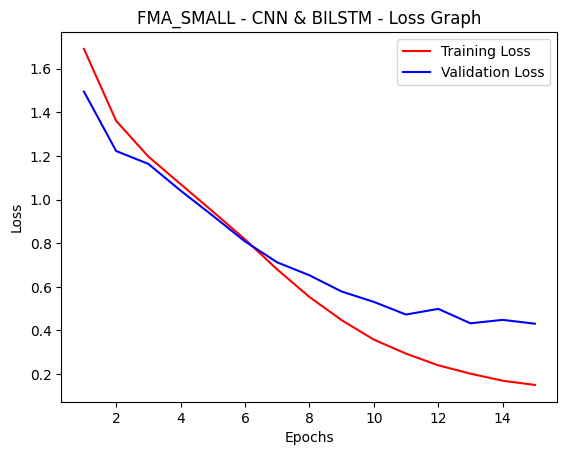

In [23]:
epochs = [i for i in range(1, 16)]

plt.plot(epochs, Training_History.history['loss'], label="Training Loss", color='red')
plt.plot(epochs, Training_History.history['val_loss'], label="Validation Loss", color='blue')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("FMA_SMALL - CNN & BILSTM - Loss Graph")
plt.legend()
plt.show()

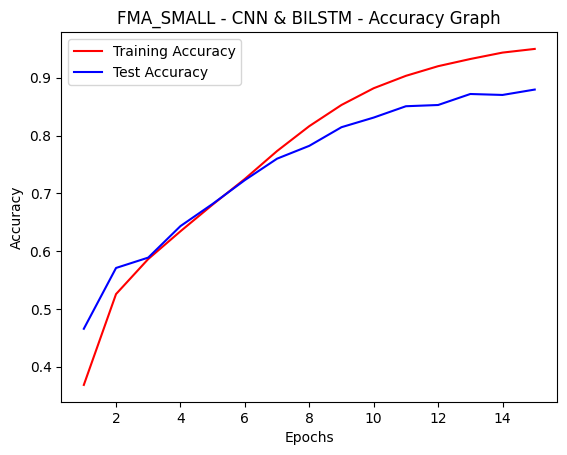

In [22]:
epochs = [i for i in range(1, 16)]

plt.plot(epochs, Training_History.history['accuracy'], label = "Training Accuracy", color = 'red')
plt.plot(epochs, Training_History.history['val_accuracy'], label = "Test Accuracy", color = 'blue')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("FMA_SMALL - CNN & BILSTM - Accuracy Graph")
plt.legend()
plt.show()

## **Metrics**

In [20]:
YPred = model.predict(XTest)
print("YPred Shape:", YPred.shape)

721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
YPred Shape: (23054, 8)


In [24]:
predictedCategories = np.argmax(YPred, axis=1)
trueCategories = np.argmax(YTest, axis=1)

In [25]:
print("Predicted Categories:", predictedCategories)
print("True Categories:", trueCategories)

Predicted Categories: [5 2 4 ... 4 1 0]
True Categories: [5 6 4 ... 4 1 0]


In [26]:
cm = confusion_matrix(trueCategories, predictedCategories)
print(classification_report(trueCategories, predictedCategories, target_names=classes))

               precision    recall  f1-score   support

          Pop       0.85      0.79      0.82      2955
 Instrumental       0.80      0.92      0.86      2898
International       0.92      0.91      0.91      2802
      Hip-Hop       0.90      0.94      0.92      2910
         Folk       0.89      0.85      0.87      2959
 Experimental       0.90      0.82      0.86      2861
         Rock       0.88      0.93      0.90      2797
   Electronic       0.91      0.87      0.89      2872

     accuracy                           0.88     23054
    macro avg       0.88      0.88      0.88     23054
 weighted avg       0.88      0.88      0.88     23054



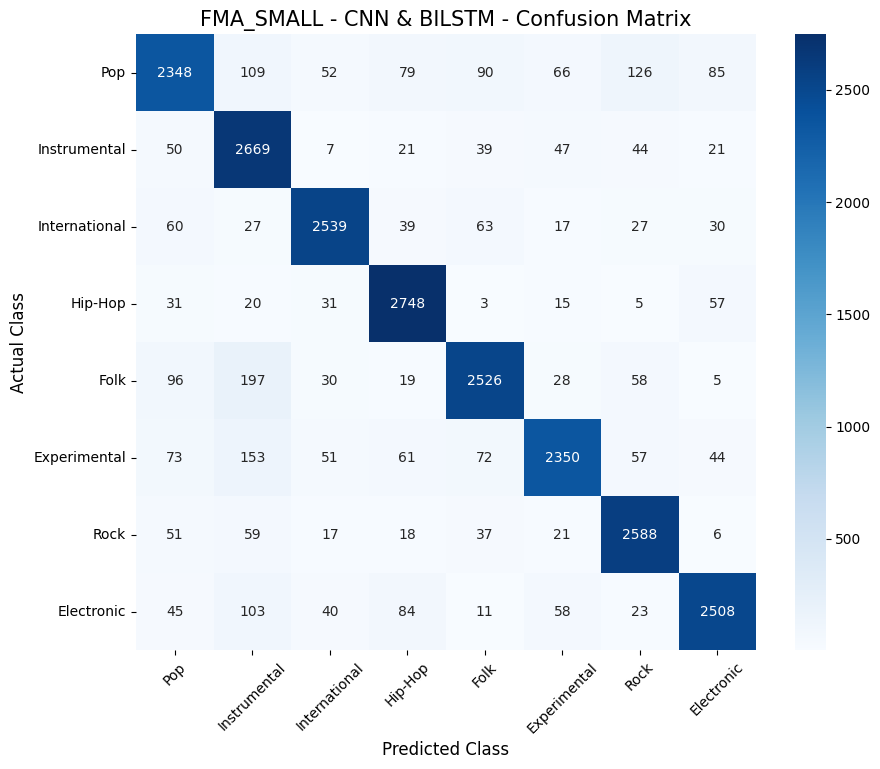

In [30]:
cm = confusion_matrix(trueCategories, predictedCategories)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("FMA_SMALL - CNN & BILSTM - Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

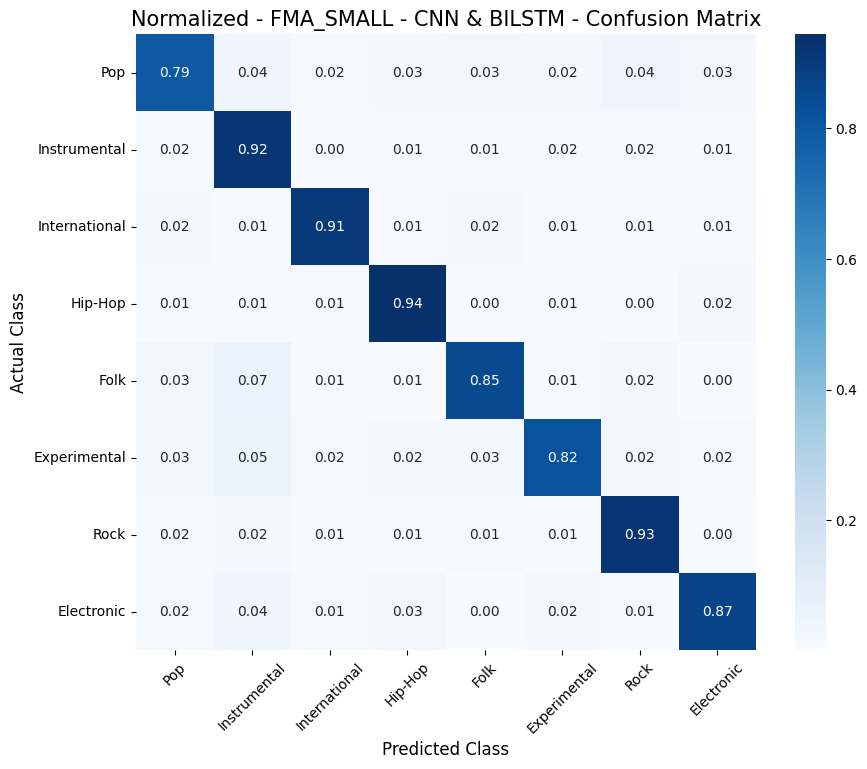

In [31]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Normalized - FMA_SMALL - CNN & BILSTM - Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()